## XGBoost Classifier for the cancer diagnosis

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install shap

In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [4]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report

In [5]:
from sklearn.decomposition import PCA

In [6]:
project_path = "/content/drive/MyDrive/Colab Notebooks/cancer_diagnosis/"
data_path = project_path + "data/"

In [7]:
data_df = pd.read_csv(data_path + "data.csv")
data_df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [8]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

In [9]:
columns_to_drop = ["id", "Unnamed: 32"]
data_df = data_df.drop(columns=columns_to_drop, axis = 1)

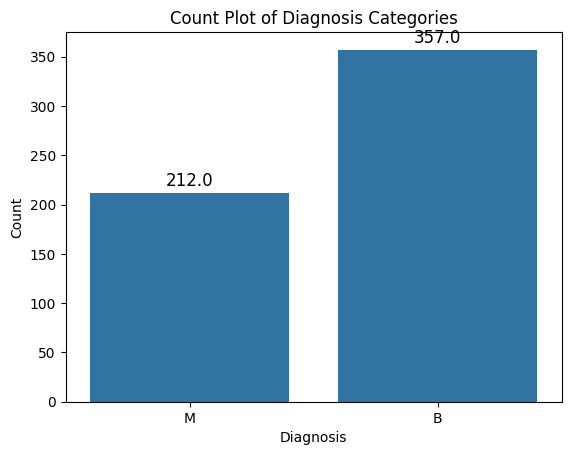

In [10]:
ax = sns.countplot(x="diagnosis", data=data_df)

for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='baseline', fontsize=12, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.title('Count Plot of Diagnosis Categories')
plt.xlabel('Diagnosis')
plt.ylabel('Count')
plt.show()

In [11]:
y = data_df["diagnosis"].values
labelencoder = LabelEncoder()
labelencoder = labelencoder.fit(y)
Y = labelencoder.transform(y)
print(np.unique(Y))

[0 1]


In [12]:
labelencoder.inverse_transform(np.array([0, 1]))

array(['B', 'M'], dtype=object)

In [13]:
X = data_df.drop(columns = ["diagnosis"], axis = 1)
X.head()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


### Feature Scaling

In [14]:
scaler = MinMaxScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)
X_scaled.shape

(569, 30)

### Train Test Split

In [15]:
X_scaled = pd.DataFrame(X_scaled, columns = X.columns)
X_scaled.head()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,0.521037,0.022658,0.545989,0.363733,0.593753,0.792037,0.703140,0.731113,0.686364,0.605518,...,0.620776,0.141525,0.668310,0.450698,0.601136,0.619292,0.568610,0.912027,0.598462,0.418864
1,0.643144,0.272574,0.615783,0.501591,0.289880,0.181768,0.203608,0.348757,0.379798,0.141323,...,0.606901,0.303571,0.539818,0.435214,0.347553,0.154563,0.192971,0.639175,0.233590,0.222878
2,0.601496,0.390260,0.595743,0.449417,0.514309,0.431017,0.462512,0.635686,0.509596,0.211247,...,0.556386,0.360075,0.508442,0.374508,0.483590,0.385375,0.359744,0.835052,0.403706,0.213433
3,0.210090,0.360839,0.233501,0.102906,0.811321,0.811361,0.565604,0.522863,0.776263,1.000000,...,0.248310,0.385928,0.241347,0.094008,0.915472,0.814012,0.548642,0.884880,1.000000,0.773711
4,0.629893,0.156578,0.630986,0.489290,0.430351,0.347893,0.463918,0.518390,0.378283,0.186816,...,0.519744,0.123934,0.506948,0.341575,0.437364,0.172415,0.319489,0.558419,0.157500,0.142595


In [16]:
Y.shape, X_scaled.shape

((569,), (569, 30))

In [17]:
X_train, X_rem, y_train, y_rem = train_test_split(X_scaled, Y, test_size = 0.2, random_state = 42)
X_val, X_test, y_val, y_test = train_test_split(X_rem, y_rem, test_size = 0.5, random_state = 42)
print("Shape of training data is  : ", X_train.shape, y_train.shape)
print("Shape of validation data is : ", X_val.shape, y_val.shape)
print("Shape of test data is : ", X_test.shape, y_test.shape)

Shape of training data is  :  (455, 30) (455,)
Shape of validation data is :  (57, 30) (57,)
Shape of test data is :  (57, 30) (57,)


In [48]:
def get_labeled_data(X, y, split = "train", drop_label = False):
  """
  Arguments:
    X : dataframe with features
    y : corresponding labels
  Outputs:
    X_df : dataframe with label concantenated and split_label
  """
  if len(X) != len(y):
    raise ValueError(f"length must be equal : len(X) != len(y)")
  X_df = X.copy()
  X_df["label"] = y
  X_df["split_label"] = np.where(X_df["label"] == 0, f"{split}_0", f"{split}_1")
  if drop_label:
    X_df = X_df.drop(["label"], axis = 1)
  return X_df.reset_index().drop(columns = "index")

In [49]:
train_df = get_labeled_data(X_train, y_train, split = "train", drop_label = True)
val_df = get_labeled_data(X_val, y_val, split = "val", drop_label = True)
test_df = get_labeled_data(X_test, y_test, split = "test", drop_label = True)

In [50]:
display(train_df.head())
display(val_df.head())
display(test_df.head())

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,split_label
0,0.096928,0.257694,0.103656,0.045387,0.487226,0.373965,0.733365,0.217445,0.530808,0.642376,...,0.283316,0.075153,0.034285,0.508684,0.397018,1.000000,0.601375,0.524936,0.409681,train_0
1,0.667755,0.570172,0.683505,0.495228,0.554934,0.809214,0.582709,0.743539,0.674242,0.505897,...,0.571962,0.627970,0.467902,0.514627,0.709327,0.541534,0.997595,0.499310,0.481175,train_1
2,0.103744,0.140345,0.106489,0.049799,0.221901,0.208975,0.140300,0.108350,0.646970,0.414280,...,0.192164,0.075601,0.030697,0.179555,0.136324,0.111581,0.174811,0.338459,0.195855,train_0
3,0.173648,0.524518,0.167369,0.086320,0.396678,0.162444,0.055740,0.080268,0.422727,0.280750,...,0.617537,0.137308,0.066482,0.519910,0.109158,0.089856,0.210859,0.363493,0.173357,train_0
4,0.150930,0.174839,0.143459,0.071432,0.548614,0.187811,0.025398,0.064115,0.850000,0.413648,...,0.144723,0.096867,0.045075,0.371987,0.069244,0.017316,0.088625,0.392667,0.165027,train_0


,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,split_label
0,0.309953,0.041596,0.304886,0.176331,0.690349,0.261702,0.161129,0.325845,0.678283,0.346462,...,0.012527,0.203944,0.103298,0.488212,0.107314,0.068203,0.254536,0.225705,0.110652,val_0
1,0.300961,0.207981,0.295073,0.159703,0.498059,0.411386,0.273899,0.347266,0.445455,0.401432,...,0.297708,0.230340,0.105609,0.544344,0.438348,0.388019,0.586942,0.386753,0.305392,val_0
2,0.518198,0.499493,0.493470,0.362842,0.324276,0.156095,0.133529,0.235785,0.241414,0.108256,...,0.604211,0.421784,0.278903,0.398402,0.148742,0.166134,0.390378,0.185098,0.160304,val_1
3,0.279663,0.202570,0.278419,0.158261,0.230658,0.234403,0.261246,0.168489,0.187879,0.197767,...,0.204424,0.207729,0.100865,0.185498,0.198320,0.267093,0.349485,0.085551,0.106454,val_0
4,0.439159,0.411566,0.440260,0.289841,0.576600,0.334090,0.421509,0.396670,0.408586,0.323505,...,0.351546,0.315205,0.194160,0.471703,0.178818,0.267093,0.359794,0.230830,0.160632,val_1


,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,split_label
0,0.434427,0.400068,0.431276,0.282630,0.434865,0.334397,0.244377,0.278976,0.555556,0.188500,...,0.523987,0.394890,0.243266,0.451232,0.269921,0.238978,0.450859,0.377489,0.138725,test_1
1,0.215770,0.159959,0.213254,0.110032,0.426198,0.284093,0.157849,0.128926,0.382828,0.376158,...,0.204158,0.141292,0.066998,0.418213,0.179013,0.143530,0.237732,0.150601,0.172504,test_0
2,0.166075,0.323977,0.163223,0.081697,0.426650,0.203668,0.070173,0.059692,0.584343,0.312763,...,0.300906,0.118582,0.053480,0.335006,0.117696,0.063794,0.110069,0.248571,0.134330,test_0
3,0.283923,0.326006,0.281459,0.157158,0.389636,0.285627,0.166518,0.146620,0.354040,0.325190,...,0.264659,0.243040,0.110377,0.380572,0.289131,0.274681,0.338763,0.400355,0.240194,test_0
4,0.294808,0.525533,0.278557,0.167296,0.318498,0.100209,0.064948,0.102783,0.282323,0.123842,...,0.591951,0.203596,0.110032,0.381232,0.076656,0.111022,0.206357,0.173270,0.084219,test_0


In [51]:
# final_df_with_all_split = pd.concat([train_df, val_df, test_df], axis = 0, ignore_index = True)
# final_df_with_all_split.head()

In [52]:
feature_columns = list(train_df.columns)
feature_columns.remove("split_label")
print(feature_columns)

['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean', 'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean', 'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se', 'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se', 'fractal_dimension_se', 'radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst', 'smoothness_worst', 'compactness_worst', 'concavity_worst', 'concave points_worst', 'symmetry_worst', 'fractal_dimension_worst']


In [73]:
N_COMPONENTS = 3
pca = PCA(n_components = N_COMPONENTS)
pca.fit(train_df[feature_columns])

PCA(n_components=3)

In [74]:
def get_pca_df(pca, feature_df, label_series):
  """
  get the dataframe with PCA applied

  Argument:
    pca : fit pca model
    feature_df : dataframe containing the relevant feature to apply PCA
    label_series : series of the labels to be concatenated

  Output:
    pca_df : dataframe with 3 Principal Component and a split_label
  """


  pca_df = pca.transform(feature_df)

  # folowing code is added in case 2d visualization is needed
  if pca_df.shape[1] == 3:
    pca_df_columns = ["PC1", "PC2", "PC3"]
  else:
    pca_df_columns = ["PC1", "PC2"]
  pca_df = pd.DataFrame(pca_df, columns = pca_df_columns)

  pca_df["split_label"] = label_series
  return pca_df

In [75]:
train_pca_df = get_pca_df(pca, train_df[feature_columns], train_df["split_label"])
val_pca_df = get_pca_df(pca, val_df[feature_columns], val_df["split_label"])
test_pca_df = get_pca_df(pca, test_df[feature_columns], test_df["split_label"])

In [76]:
val_pca_df.head()

,PC1,PC2,PC3,split_label
0,-0.171925,0.219632,0.412414,val_0
1,0.235214,0.388769,-0.048761,val_0
2,0.116946,-0.467319,-0.233397,val_1
3,-0.218658,-0.026793,0.238875,val_0
4,0.293000,0.093727,0.179102,val_1


In [77]:
fig = px.scatter_3d(train_pca_df, x='PC1', y='PC2', z='PC3', color='split_label', title='Train Split \n 3-d feature plot ')
fig.show()

In [78]:
fig = px.scatter_3d(val_pca_df, x='PC1', y='PC2', z='PC3', color='split_label', title='Validation Split \n 3-d feature plot ')
fig.show()

In [79]:
fig = px.scatter_3d(test_pca_df, x='PC1', y='PC2', z='PC3', color='split_label', title='Validation Split \n 3-d feature plot ')
fig.show()

### 2D plot

In [81]:
N_COMPONENTS = 2
pca = PCA(n_components = N_COMPONENTS)
pca.fit(train_df[feature_columns])

train_pca_df = get_pca_df(pca, train_df[feature_columns], train_df["split_label"])
val_pca_df = get_pca_df(pca, val_df[feature_columns], val_df["split_label"])
test_pca_df = get_pca_df(pca, test_df[feature_columns], test_df["split_label"])

In [82]:
train_pca_df.head()

,PC1,PC2,split_label
0,0.445849,1.189845,train_0
1,1.521691,0.178700,train_1
2,-0.494587,0.400806,train_0
3,-0.419136,0.114216,train_0
4,-0.528228,0.348397,train_0


In [87]:
fig = px.scatter(train_pca_df, x='PC1', y='PC2', color='split_label', title='Train Split \n 2D Scatter Plot')
fig.show()

fig = px.scatter(val_pca_df, x='PC1', y='PC2', color='split_label', title='Validation Split \n 2D Scatter Plot')
fig.show()

fig = px.scatter(test_pca_df, x='PC1', y='PC2', color='split_label', title='Test Split \n 2D Scatter Plot')
fig.show()